# **Checking the python version**

In [2]:
!python3 --version

Python 3.10.12


# Installing some packages

In [1]:
!pip install openmeteo_requests
!pip install pandas
!pip install requests_cache
!pip install retry_requests

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.8/50.8 kB 7.0 MB/s eta 0:00:00


# Fetching Dhaka weather data from 1940 and saving the data in a dataframe

In [1]:
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry

cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)


url = "https://archive-api.open-meteo.com/v1/archive"

params = {
            "latitude": 23.8103,  # Dhaka latitude
            "longitude": 90.4125,  # Dhaka longitude
            "start_date": "1940-01-01",
            "end_date": "2023-11-10",
            "hourly": "temperature_2m"
        }
responses = openmeteo.weather_api(url, params=params)

response = responses[0]
print(f"Coordinates {response.Latitude()}°E {response.Longitude()}°N")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()

if hourly_temperature_2m.size == 0:
    print("No temperature data available for the specified date range.")
else:
    hourly_data = {"date": pd.date_range(
    start = pd.to_datetime(hourly.Time(), unit = "s"),
    end = pd.to_datetime(hourly.TimeEnd(), unit = "s"),
    freq = pd.Timedelta(seconds = hourly.Interval()),
    inclusive = "left"
            )}
    hourly_data["temperature_2m"] = hourly_temperature_2m

    df = pd.DataFrame(data = hourly_data)

if df['temperature_2m'].isnull().values.any():
    print("Null values found in temperature data. Replacing with appropriate value.")

    df['temperature_2m'].fillna(method='ffill', inplace=True)

    print(df)


    # df.to_csv('weather_data.csv', index=False)








Coordinates 23.796133041381836°E 90.38054656982422°N
Elevation 19.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
Null values found in temperature data. Replacing with appropriate value.
                      date  temperature_2m
0      1940-01-01 00:00:00       14.178500
1      1940-01-01 01:00:00       14.778501
2      1940-01-01 02:00:00       16.078499
3      1940-01-01 03:00:00       19.978498
4      1940-01-01 04:00:00       23.078499
...                    ...             ...
735115 2023-11-10 19:00:00       18.598000
735116 2023-11-10 20:00:00       18.598000
735117 2023-11-10 21:00:00       18.598000
735118 2023-11-10 22:00:00       18.598000
735119 2023-11-10 23:00:00       18.598000

[735120 rows x 2 columns]


/var/folders/0g/w9ygy7td6d7954y3_8q_sz8h0000gn/T/ipykernel_37043/4293547713.py:47: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['temperature_2m'].fillna(method='ffill', inplace=True)


# Checking the dataframe and its distribution

In [2]:
df.head(100)

,date,temperature_2m
0,1940-01-01 00:00:00,14.178500
1,1940-01-01 01:00:00,14.778501
2,1940-01-01 02:00:00,16.078499
3,1940-01-01 03:00:00,19.978498
4,1940-01-01 04:00:00,23.078499
...,...,...
95,1940-01-04 23:00:00,11.928500
96,1940-01-05 00:00:00,11.428500
97,1940-01-05 01:00:00,11.378500
98,1940-01-05 02:00:00,15.028501


# Check null values in the dataframe

In [3]:
null_counts = df.isnull().sum()

# Print or use the result as needed
print(null_counts)

date              0
temperature_2m    0
dtype: int64


# Describe the dataframe

In [4]:
df.describe()

,date,temperature_2m
count,735120,735120.000000
mean,1981-12-05 23:30:00,25.125923
min,1940-01-01 00:00:00,7.448000
25%,1960-12-18 11:45:00,22.648001
50%,1981-12-05 23:30:00,25.997999
75%,2002-11-23 11:15:00,28.247999
max,2023-11-10 23:00:00,42.448002
std,NaN,4.872819


In [5]:
df.shape

(735120, 2)

In [6]:
df.dtypes

date              datetime64[ns]
temperature_2m           float32
dtype: object

# Ploting the dataframe

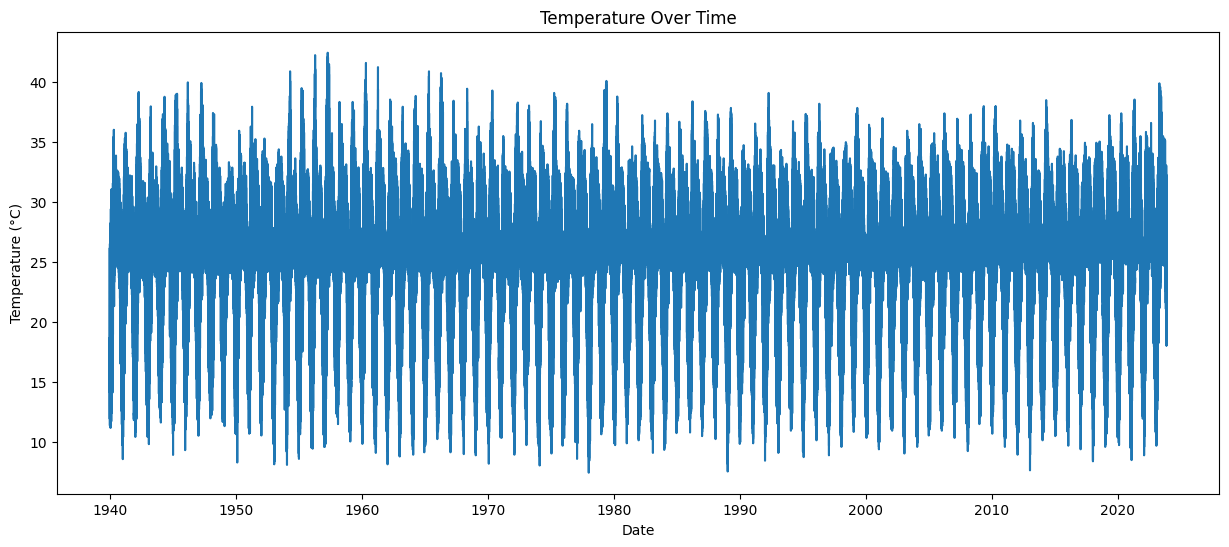

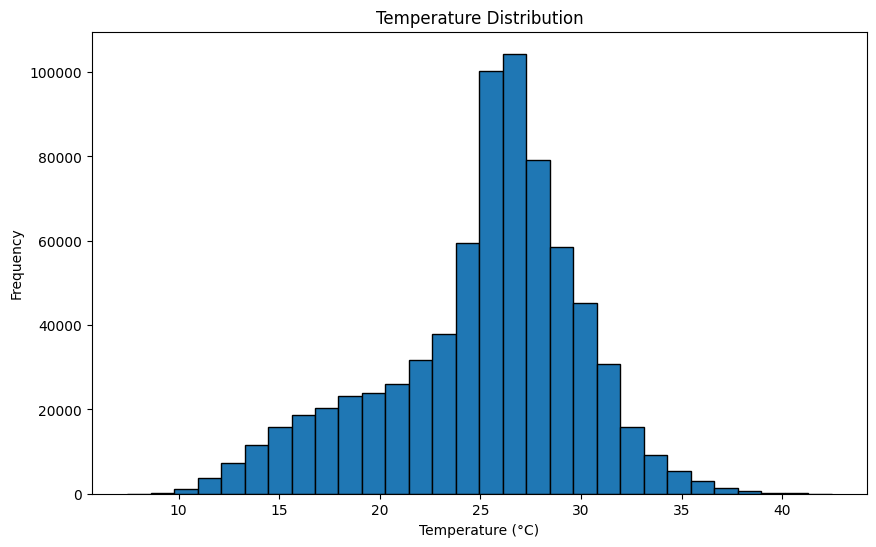

In [7]:
import matplotlib.pyplot as plt

df.set_index('date', inplace=True)

# Plot the time series data
plt.figure(figsize=(15, 6))
plt.plot(df['temperature_2m'])
plt.title('Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.show()

# Plot a histogram of temperature values
plt.figure(figsize=(10, 6))
plt.hist(df['temperature_2m'], bins=30, edgecolor='black')
plt.title('Temperature Distribution')
plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency')
plt.show()


In [7]:
df


,date,temperature_2m
0,1940-01-01 00:00:00,14.178500
1,1940-01-01 01:00:00,14.778501
2,1940-01-01 02:00:00,16.078499
3,1940-01-01 03:00:00,19.978498
4,1940-01-01 04:00:00,23.078499
...,...,...
735115,2023-11-10 19:00:00,18.598000
735116,2023-11-10 20:00:00,18.598000
735117,2023-11-10 21:00:00,18.598000
735118,2023-11-10 22:00:00,18.598000


# Line Plot for Last 10 years

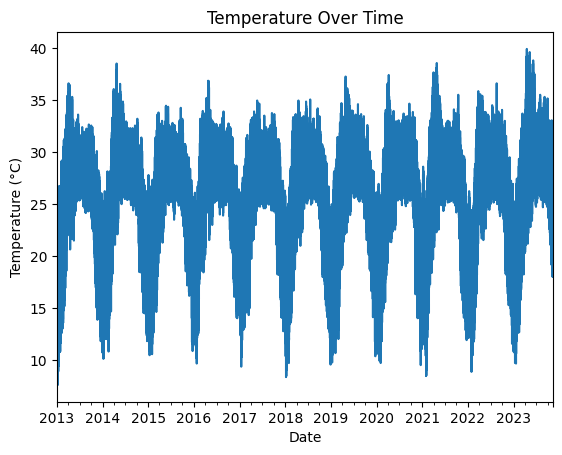

In [9]:
import matplotlib.pyplot as plt


# Plotting
df.loc['2013-01-01':].plot(y='temperature_2m', kind='line', legend=False)
plt.title('Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.show()

# print(df.loc['2013-01-01':])

In [24]:
df.dtypes

date              datetime64[ns]
temperature_2m           float32
dtype: object

In [25]:

!pip install prophet

Original DataFrame columns: Index(['ds', 'y'], dtype='object')
DataFrame columns after renaming: Index(['ds', 'y'], dtype='object')


23:24:22 - cmdstanpy - INFO - Chain [1] start processing
23:30:16 - cmdstanpy - INFO - Chain [1] done processing
/Users/afrozanowshin/.pyenv/versions/3.10.12/envs/env-3.10.12/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/afrozanowshin/.pyenv/versions/3.10.12/envs/env-3.10.12/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
/Users/afrozanowshin/.pyenv/versions/3.10.12/envs/env-3.10.12/lib/python3.

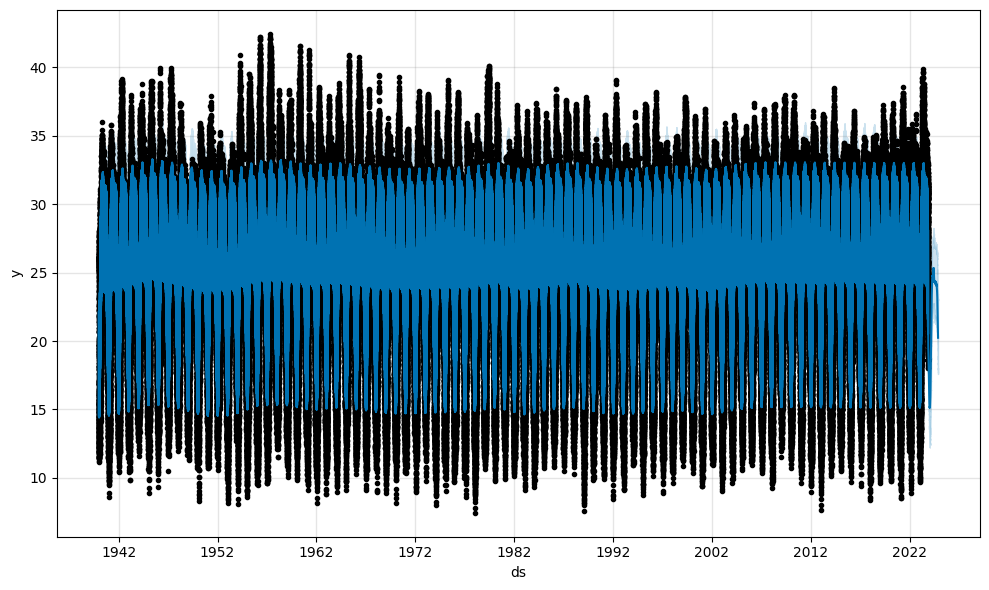

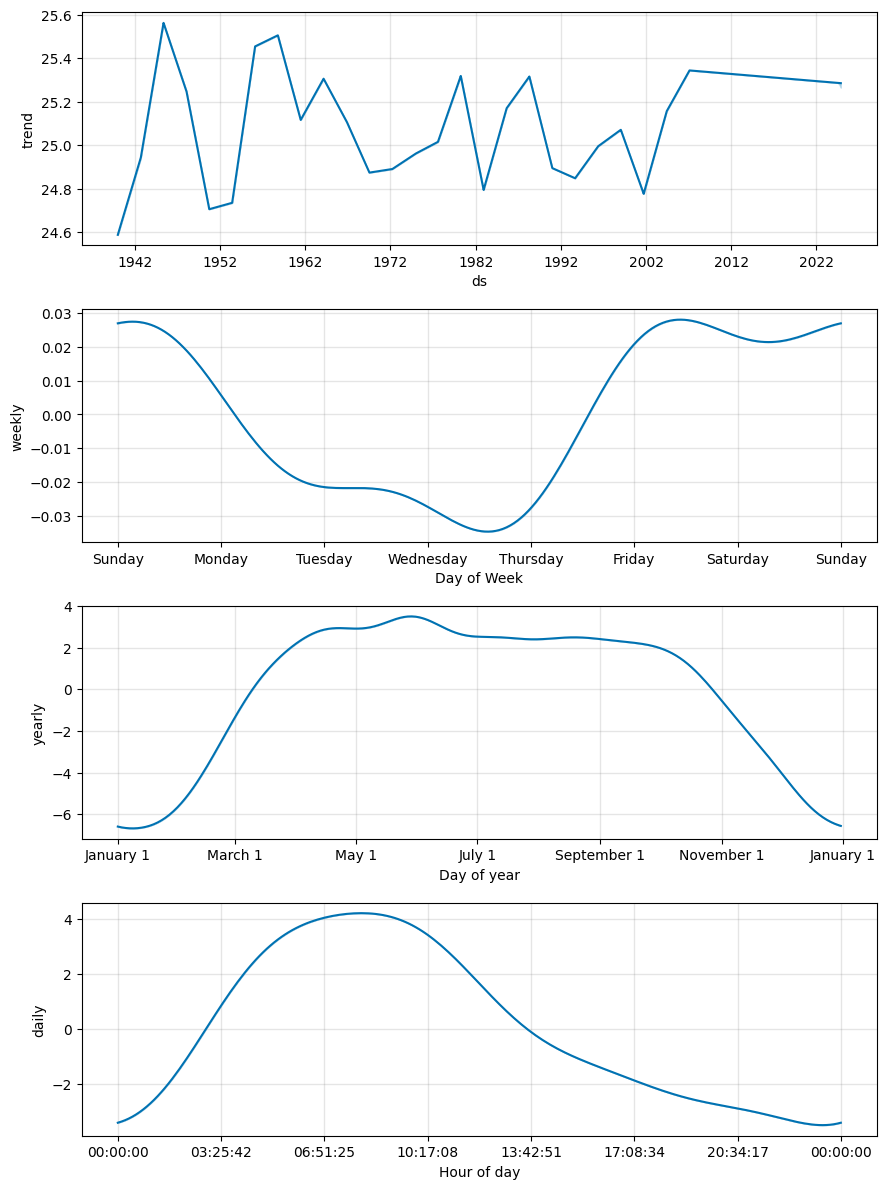

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1940-01-01 00:00:00,24.587241,11.772071,17.218215,24.587241,24.587241,-9.975328,-9.975328,-9.975328,-3.407237,...,0.005657,0.005657,0.005657,-6.573749,-6.573749,-6.573749,0.0,0.0,0.0,14.611913
1,1940-01-01 01:00:00,24.587256,12.639332,17.936798,24.587256,24.587256,-9.355285,-9.355285,-9.355285,-2.784290,...,0.003845,0.003845,0.003845,-6.574841,-6.574841,-6.574841,0.0,0.0,0.0,15.231971
2,1940-01-01 02:00:00,24.587271,13.630958,18.984207,24.587271,24.587271,-8.101346,-8.101346,-8.101346,-1.527453,...,0.002034,0.002034,0.002034,-6.575926,-6.575926,-6.575926,0.0,0.0,0.0,16.485925
3,1940-01-01 03:00:00,24.587286,15.470076,20.935009,24.587286,24.587286,-6.455815,-6.455815,-6.455815,0.120957,...,0.000234,0.000234,0.000234,-6.577006,-6.577006,-6.577006,0.0,0.0,0.0,18.131470
4,1940-01-01 04:00:00,24.587301,16.975014,22.497552,24.587301,24.587301,-4.846053,-4.846053,-4.846053,1.733569,...,-0.001543,-0.001543,-0.001543,-6.578080,-6.578080,-6.578080,0.0,0.0,0.0,19.741248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735480,2024-11-05 23:00:00,25.285635,18.055492,23.463798,25.265381,25.287327,-4.640061,-4.640061,-4.640061,-3.466384,...,-0.026553,-0.026553,-0.026553,-1.147124,-1.147124,-1.147124,0.0,0.0,0.0,20.645574
735481,2024-11-06 23:00:00,25.285626,17.750459,23.290400,25.265223,25.287374,-4.757624,-4.757624,-4.757624,-3.466384,...,-0.028938,-0.028938,-0.028938,-1.262302,-1.262302,-1.262302,0.0,0.0,0.0,20.528002
735482,2024-11-07 23:00:00,25.285617,17.779026,23.088528,25.265148,25.287422,-4.824098,-4.824098,-4.824098,-3.466384,...,0.019276,0.019276,0.019276,-1.376989,-1.376989,-1.376989,0.0,0.0,0.0,20.461519
735483,2024-11-08 23:00:00,25.285608,17.591753,22.962788,25.265047,25.287433,-4.934133,-4.934133,-4.934133,-3.466384,...,0.023423,0.023423,0.023423,-1.491171,-1.491171,-1.491171,0.0,0.0,0.0,20.351475


In [9]:
import matplotlib.pyplot as plt
from prophet import Prophet

print("Original DataFrame columns:", df.columns)

# Rename columns to match Prophet's requirements
df = df.rename({'date': 'ds', 'temperature_2m': 'y'}, axis=1)

# Check the column names after renaming
print("DataFrame columns after renaming:", df.columns)
# Model fit
m = Prophet()
m.fit(df)

# Predict
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

# Plot results
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)
plt.show()
forecast


In [11]:
from prophet.serialize import model_to_json, model_from_json

with open('model.json', 'w') as fout:
    fout.write(model_to_json(m))


In [12]:
with open('model.json', 'r') as fin:
    m = model_from_json(fin.read()) 

In [13]:
print(m)